# Read soil quality data from Excel

In [1]:
import pandas as pd
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyBboxPatch, Patch
plt.rcParams["figure.dpi"] = 150
plt.rcParams["savefig.dpi"] = 300

land_use_types = {
    0: "All",
    7: "Agricultural",
    8: "Residential",
    9: "Industrial",
    11: "Non-developed",
}
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]
# Arsenic (As), Barium (Ba), Cadmium (Cd), Chromium (Cr Total), Copper (Cu), Lead (Pb), Manganese (Mn), Nickel (Ni), Zinc (Zn), Antimony (Sb),  Cobalt (Co), and Strontium (Sr)
element_dict = {
    "ECe": "satec",
    "pH": "satph",
    "As": "Arsenic",
    "Ba": "Barium",
    "Cd": "Cadmium",
    "Co": "Cobalt",
    "Cr (Total)": "Chromium_Total",
    "Cu": "Copper",
    "Mn": "Manganese",
    "Ni": "Nickel_aqua",
    "Pb": "Lead_aqua",
    "Sb": "Antimony",
    "Sr": "Strontium",
    "Zn": "Zinc",
}

df = pd.read_excel(
    '../Result_hmq/Soil quality data QC/Soil quality data QC 2025.xlsx',
    sheet_name='Processed_Data'
)

df = df[
    (df["PHUID"] == 1) &
    (df["PHSampleUID"] == 1)
]
agr_df = df[df["SurveyID"] == 7]
res_df = df[df["SurveyID"] == 8]
ind_df = df[df["SurveyID"] == 9]
non_df = df[df["SurveyID"] == 11]

OUT_DIR = r"../Result_hmq/Ch12_Figures"
os.makedirs(OUT_DIR, exist_ok=True)


# Principal Component Analysis (PCA) - ALL

In [2]:
# =========================
# Step 1) PCA 输入变量准备
# =========================

# 1) 选取 PCA 的列（数据列名）
feat_cols = list(element_dict.values())

# 2) 只保留数据里确实存在的列（防止字段缺失报错）
feat_cols_exist = [c for c in feat_cols if c in df.columns]
feat_cols_missing = [c for c in feat_cols if c not in df.columns]
print("[INFO] PCA features:", feat_cols_exist)
if feat_cols_missing:
    print("[WARN] Missing PCA columns (ignored):", feat_cols_missing)

# 3) 只保留四类 land use（避免把 SurveyID=0 / 其它混进来）
df_pca = df[df["SurveyID"].isin([7, 8, 9, 11])].copy()

# 4) 强制转成数值（非数值会变 NaN）
for c in feat_cols_exist:
    df_pca[c] = pd.to_numeric(df_pca[c], errors="coerce")

# 5) 去掉 PCA 变量里有缺失的样本
before = len(df_pca)
df_pca = df_pca.dropna(subset=feat_cols_exist).copy()
after = len(df_pca)
print(f"[INFO] PCA rows: {before} -> {after} (dropped {before-after} rows with NaN)")

# ✅ 6) 重置索引（你之前的 IndexError 的根因就在这里）
df_pca = df_pca.reset_index(drop=True)

# 7) 准备 X 矩阵
X = df_pca[feat_cols_exist].to_numpy()
print("[INFO] X shape:", X.shape)

# 8) 同步准备标签（画图会用）
y_landuse = df_pca["SurveyID"].to_numpy()


[INFO] PCA features: ['satec', 'satph', 'Arsenic', 'Barium', 'Cadmium', 'Cobalt', 'Chromium_Total', 'Copper', 'Manganese', 'Nickel_aqua', 'Lead_aqua', 'Antimony', 'Strontium', 'Zinc']
[INFO] PCA rows: 709 -> 659 (dropped 50 rows with NaN)
[INFO] X shape: (659, 14)


In [3]:
# =========================
# Step 2) Standardization + PCA
# =========================
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 1) 标准化
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

print("[INFO] Standardized X shape:", X_std.shape)
print("[INFO] Mean (first 5 vars):", X_std.mean(axis=0)[:5])
print("[INFO] Std  (first 5 vars):", X_std.std(axis=0)[:5])

# 2) PCA（先算到最多 10 个主成分，和你 scree plot 一致）
n_pc = min(10, X_std.shape[1])
pca = PCA(n_components=n_pc)
scores = pca.fit_transform(X_std)

# 3) 解释方差
explained_var = pca.explained_variance_ratio_
explained_pct = explained_var * 100

print("\n[INFO] Explained variance ratio (%):")
for i, v in enumerate(explained_pct, start=1):
    print(f"  PC{i}: {v:.2f}%")

print("\n[INFO] Cumulative explained variance (%):")
cum = np.cumsum(explained_pct)
for i, v in enumerate(cum, start=1):
    print(f"  PC1–PC{i}: {v:.2f}%")

# 4) Loadings（变量在各 PC 上的权重）
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols_exist,
    columns=[f"PC{i}" for i in range(1, n_pc + 1)]
)

print("\n[INFO] Loadings (head):")
display(loadings.iloc[:, :4])


[INFO] Standardized X shape: (659, 14)
[INFO] Mean (first 5 vars): [ 2.15642712e-17  1.49871685e-15 -7.11620949e-16 -4.31285424e-17
  6.46928136e-17]
[INFO] Std  (first 5 vars): [1. 1. 1. 1. 1.]

[INFO] Explained variance ratio (%):
  PC1: 40.94%
  PC2: 17.60%
  PC3: 9.96%
  PC4: 8.00%
  PC5: 4.43%
  PC6: 3.72%
  PC7: 3.44%
  PC8: 3.07%
  PC9: 2.39%
  PC10: 2.23%

[INFO] Cumulative explained variance (%):
  PC1–PC1: 40.94%
  PC1–PC2: 58.54%
  PC1–PC3: 68.50%
  PC1–PC4: 76.49%
  PC1–PC5: 80.92%
  PC1–PC6: 84.64%
  PC1–PC7: 88.07%
  PC1–PC8: 91.14%
  PC1–PC9: 93.53%
  PC1–PC10: 95.77%

[INFO] Loadings (head):


,PC1,PC2,PC3,PC4
satec,0.179648,0.384290,-0.043426,-0.452217
satph,-0.099259,-0.410197,0.155614,0.523678
Arsenic,0.270300,0.279200,-0.109274,0.361600
Barium,0.264300,0.314266,-0.102005,0.214599
Cadmium,0.280944,0.016036,0.281627,0.345934
Cobalt,0.334071,-0.262537,-0.314013,-0.104530
Chromium_Total,0.314138,-0.284107,-0.282229,-0.149821
Copper,0.291387,-0.137760,0.219744,-0.077377
Manganese,0.334949,-0.086465,-0.173438,0.228817
Nickel_aqua,0.310346,-0.311711,-0.304722,-0.121290


In [4]:
# =========================
# Step 3) Attach PCA results to df_pca
# =========================

# 1) 把 scores 写回 df_pca
for i in range(n_pc):
    df_pca[f"PC{i+1}"] = scores[:, i]

# 2) 把 land use 名称也准备好（后面画图用）
df_pca["LandUse"] = df_pca["SurveyID"].map(land_use_types)

# 3) 快速一致性检查（非常重要）
print("[CHECK] df_pca shape:", df_pca.shape)
print("[CHECK] PC columns:", [c for c in df_pca.columns if c.startswith("PC")][:6])
print("[CHECK] Any NaN in PC columns:",
      df_pca[[f"PC{i+1}" for i in range(n_pc)]].isna().any().any())

# 4) 看一眼前几行，确认没问题
df_pca

[CHECK] df_pca shape: (659, 59)
[CHECK] PC columns: ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6']
[CHECK] Any NaN in PC columns: False


,SurveyID,SiteUID,SiteObsUID,PedonUID,PHUID,PHSampleUID,PHSubSampleUID,PHChemicalUID,Longitude,Latitude,...,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,LandUse
0,8,10004161220,3,2,1,1,1,1,54.374728,24.455875,...,-0.074901,0.863266,-0.189049,0.288304,0.034856,0.071942,-0.279224,-0.201591,-0.299872,Residential
1,8,10004121138,3,2,1,1,1,1,54.363589,24.456906,...,-0.806028,2.003114,-0.507414,0.964717,1.068755,-0.111543,0.758903,0.154382,-0.310223,Residential
2,8,10004222728,3,2,1,1,1,1,54.360639,24.460648,...,-1.393992,6.310762,0.622264,1.209004,-1.666607,-3.225331,-1.254100,0.040627,-0.793358,Residential
3,8,10004120958,8,2,1,1,1,1,54.358618,24.450317,...,-0.585925,2.359656,-1.729769,0.147469,0.678515,-0.344367,2.039292,-0.153038,-0.457676,Residential
4,8,10004318725,3,2,1,1,1,1,54.365983,24.444368,...,-0.332919,0.835991,-0.373485,0.477379,0.020455,0.117675,-0.001202,-0.049611,-0.275682,Residential
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
654,11,30042,1,2,1,1,1,1,54.959240,24.160123,...,0.310612,-0.202215,0.806754,0.092769,-0.113351,-0.074132,0.084129,0.129465,-0.223269,Non-developed
655,11,30030,1,2,1,1,1,1,54.714660,23.887750,...,0.604285,-0.059771,1.008701,0.733744,-0.009843,0.235716,0.129672,0.166169,-0.609827,Non-developed
656,11,22431,2,2,1,1,1,1,54.708353,23.649898,...,0.119165,-0.213139,0.064684,-0.640628,-0.335689,-0.197509,-0.104856,-0.620454,0.409477,Non-developed
657,11,30034,1,2,1,1,1,1,54.697735,24.729132,...,3.108018,-0.750621,1.465178,-0.359242,0.356878,-0.295735,0.023332,0.053271,1.474877,Non-developed


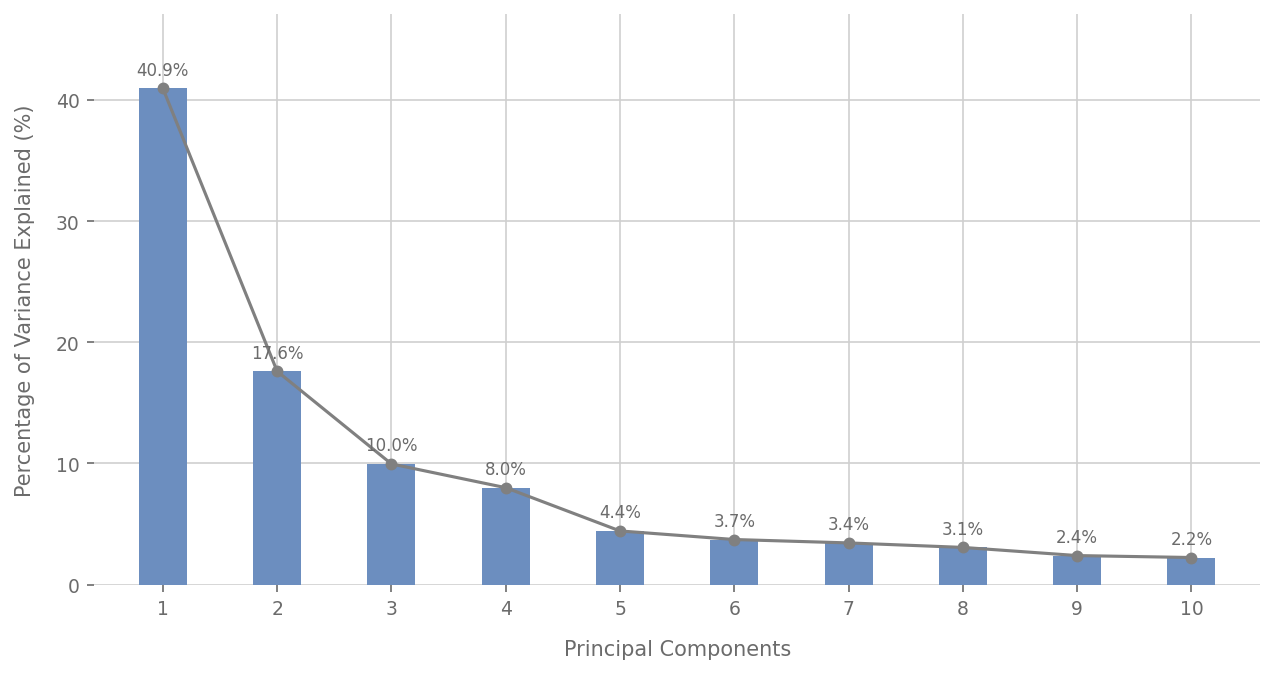

In [5]:
# =========================
# Step 4) Scree plot
# =========================

TEXT_COLOR = "#6B6B6B"

pcs = np.arange(1, n_pc + 1)
perc = explained_pct

fig, ax = plt.subplots(figsize=(8.6, 4.6), dpi=150)

# ---- background + grid (ONLY major grid) ----
ax.set_facecolor("white")
ax.grid(True, which="major", color="#cfcfcf", linewidth=0.8)
ax.minorticks_off()  # ❗关闭副刻度

# ---- bars ----
bar_w = 0.42
bar_color = "#6C8EBF"

ax.bar(
    pcs, perc,
    width=bar_w,
    color=bar_color,
    edgecolor="none",
    zorder=3
)

# ---- line + points ----
ax.plot(pcs, perc, color="grey", linewidth=1.5, zorder=4)
ax.scatter(pcs, perc, s=22, color="grey", zorder=5)

# ---- value labels ----
for x, h in zip(pcs, perc):
    ax.text(
        x, h + 0.8,
        f"{h:.1f}%",
        ha="center", va="bottom",
        fontsize=8,
        color=TEXT_COLOR,
        zorder=6
    )

# ---- axes ----
ax.set_xlim(0.4, n_pc + 0.6)
ax.set_ylim(0, max(perc) * 1.15)
ax.set_xticks(pcs)

ax.set_xlabel("Principal Components", labelpad=10, color=TEXT_COLOR)
ax.set_ylabel("Percentage of Variance Explained (%)", labelpad=10, color=TEXT_COLOR)

# ---- clean spines ----
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# ---- tick style ----
ax.tick_params(
    axis="both",
    which="major",
    labelsize=9,
    colors=TEXT_COLOR
)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_VarianceExplainedByPrincipalComponent.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_VarianceExplainedByPrincipalComponent.svg"), bbox_inches="tight", pad_inches=0.1)

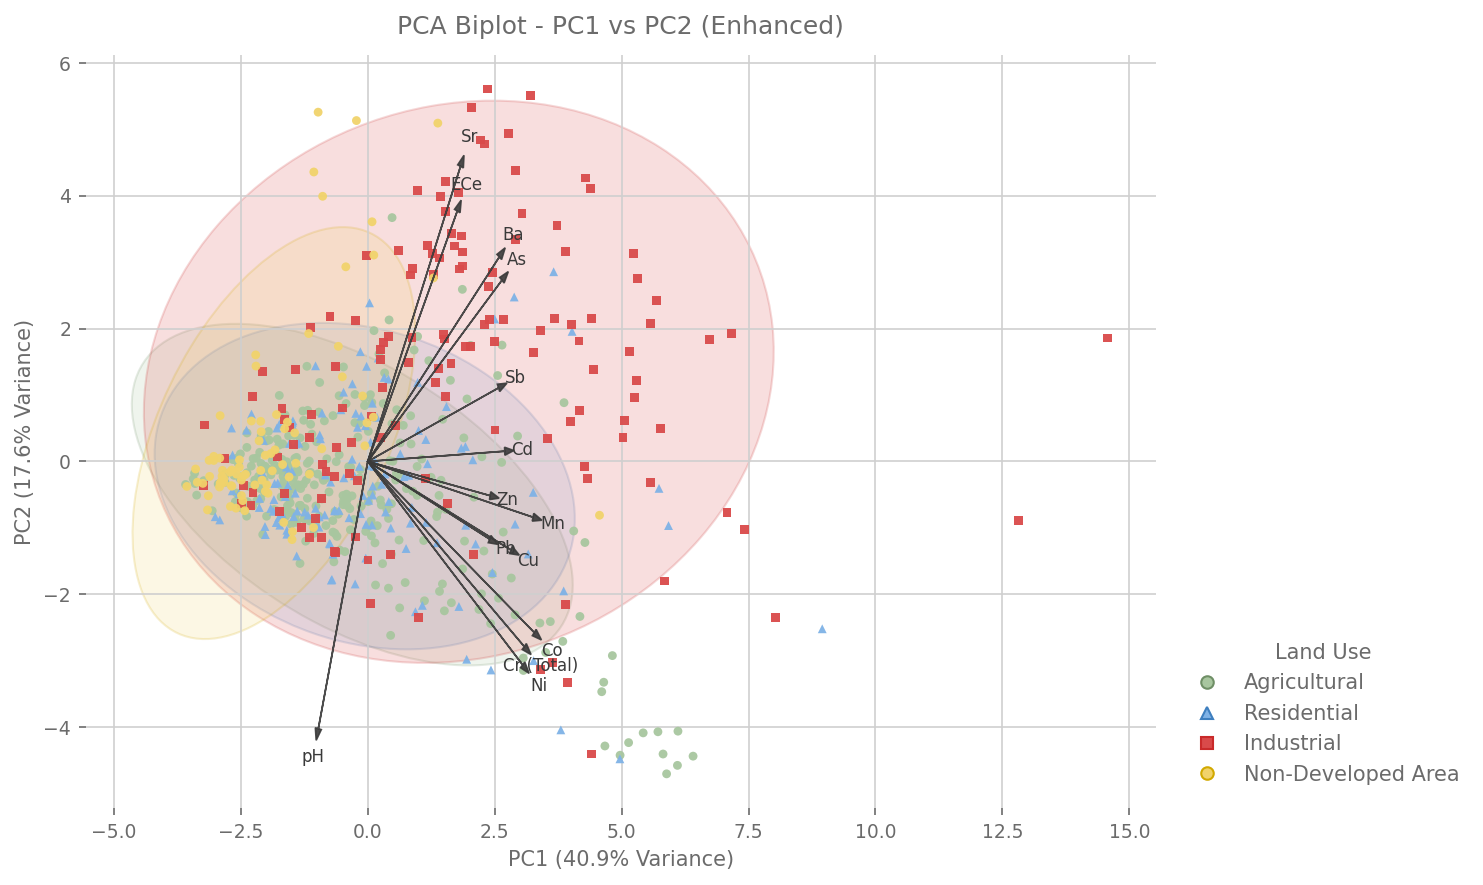

In [6]:
# =========================
# Step 5) PCA biplot PC1 vs PC2 (Enhanced)
# =========================

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

TEXT_COLOR = "#6B6B6B"
GRID_COLOR = "#cfcfcf"
ZERO_LINE_COLOR = "#7f7f7f"

# 90% chi-square quantile for df=2
CHI2_95_DF2 = 4.605


def confidence_ellipse_params(xy: np.ndarray, chi2_val: float = CHI2_95_DF2):
    """
    Return (mean_x, mean_y, width, height, angle_deg) for covariance ellipse scaled by chi-square.
    """
    if xy.shape[0] < 3:
        return None

    mu = xy.mean(axis=0)
    cov = np.cov(xy.T)

    # eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # semi-axis lengths scaled by chi2; Ellipse width/height are full lengths
    width = 2 * np.sqrt(max(eigvals[0], 0) * chi2_val)
    height = 2 * np.sqrt(max(eigvals[1], 0) * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))
    return mu[0], mu[1], width, height, angle


def add_cov_ellipse(ax, xy, facecolor, edgecolor, alpha=0.16, lw=1.0, zorder=1):
    p = confidence_ellipse_params(xy)
    if p is None:
        return
    mx, my, w, h, ang = p
    ell = Ellipse((mx, my), width=w, height=h, angle=ang,
                  facecolor=facecolor, edgecolor=edgecolor, lw=lw, alpha=alpha, zorder=zorder)
    ax.add_patch(ell)


# ---- style for land use (match your sample: green/blue/red/yellow with distinct markers) ----
STYLE = {
    7: dict(label="Agricultural",        color="#A8C69F", edge="#6F8F66", marker="o"),
    8: dict(label="Residential",         color="#7FB2E6", edge="#3E7FBF", marker="^"),
    9: dict(label="Industrial",          color="#D94A4A", edge="#C92A2A", marker="s"),
    11: dict(label="Non-Developed Area", color="#F1D36B", edge="#D2A900", marker="o"),
}

# ---- choose PCs ----
pc_x, pc_y = 1, 2
xcol, ycol = f"PC{pc_x}", f"PC{pc_y}"

# ---- build figure ----
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.set_facecolor("white")

# major grid only
ax.grid(True, which="major", color=GRID_COLOR, linewidth=0.8)
ax.minorticks_off()

# ---- scatter + ellipse per class ----
handles = []
for sid, st in STYLE.items():
    sub = df_pca[df_pca["SurveyID"] == sid]
    if sub.empty:
        continue

    xy = sub[[xcol, ycol]].to_numpy()

    ax.scatter(
        xy[:, 0], xy[:, 1],
        s=18,
        marker=st["marker"],
        c=st["color"],
        edgecolors="none",
        alpha=0.95,
        zorder=2
    )

    # 95% covariance ellipse
    add_cov_ellipse(
        ax, xy,
        facecolor=st["color"],
        edgecolor=st["edge"],
        alpha=0.18,
        lw=1.0,
        zorder=1
    )

    # legend handle
    handles.append(
        plt.Line2D([0], [0], marker=st["marker"], color="none",
                   markerfacecolor=st["color"], markeredgecolor=st["edge"],
                   markersize=6, label=st["label"])
    )

# ---- arrows (loadings) ----
# Use a scaling that fits arrows nicely relative to score spread
x_span = np.quantile(df_pca[xcol], 0.99) - np.quantile(df_pca[xcol], 0.01)
y_span = np.quantile(df_pca[ycol], 0.99) - np.quantile(df_pca[ycol], 0.01)
score_span = max(x_span, y_span)
arrow_scale = score_span  # tune if needed (0.35-0.55)

# pretty labels for features
inv_element_dict = {v: k for k, v in element_dict.items()}
feat_cols_exist = [c for c in element_dict.values() if c in df_pca.columns]
feat_labels = [inv_element_dict.get(c, c) for c in feat_cols_exist]

for col, lab in zip(feat_cols_exist, feat_labels):
    lx = float(loadings.loc[col, f"PC{pc_x}"]) * arrow_scale
    ly = float(loadings.loc[col, f"PC{pc_y}"]) * arrow_scale

    ax.arrow(
        0, 0, lx, ly,
        color="#3a3a3a",
        linewidth=0.8,
        head_width=0.12,
        head_length=0.18,
        length_includes_head=True,
        alpha=0.9,
        zorder=3
    )
    ax.text(
        lx * 1.06, ly * 1.06,
        lab,
        fontsize=8,
        color="#3a3a3a",
        ha="center", va="center",
        zorder=4
    )

# ---- labels / title ----
ax.set_title("PCA Biplot - PC1 vs PC2 (Enhanced)", color=TEXT_COLOR, pad=10)
ax.set_xlabel(f"PC1 ({explained_pct[0]:.1f}% Variance)", color=TEXT_COLOR)
ax.set_ylabel(f"PC2 ({explained_pct[1]:.1f}% Variance)", color=TEXT_COLOR)

# ticks style
ax.tick_params(axis="both", which="major", colors=TEXT_COLOR, labelsize=9)

# clean spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# legend
leg = ax.legend(
    handles=handles,
    title="Land Use",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.02),  # 👉 右侧、靠下、轴外
    frameon=False,
    borderaxespad=0.0
)
plt.setp(leg.get_title(), color=TEXT_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_GlobalPCA_PC1vsPC2.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_GlobalPCA_PC1vsPC2.svg"), bbox_inches="tight", pad_inches=0.1)

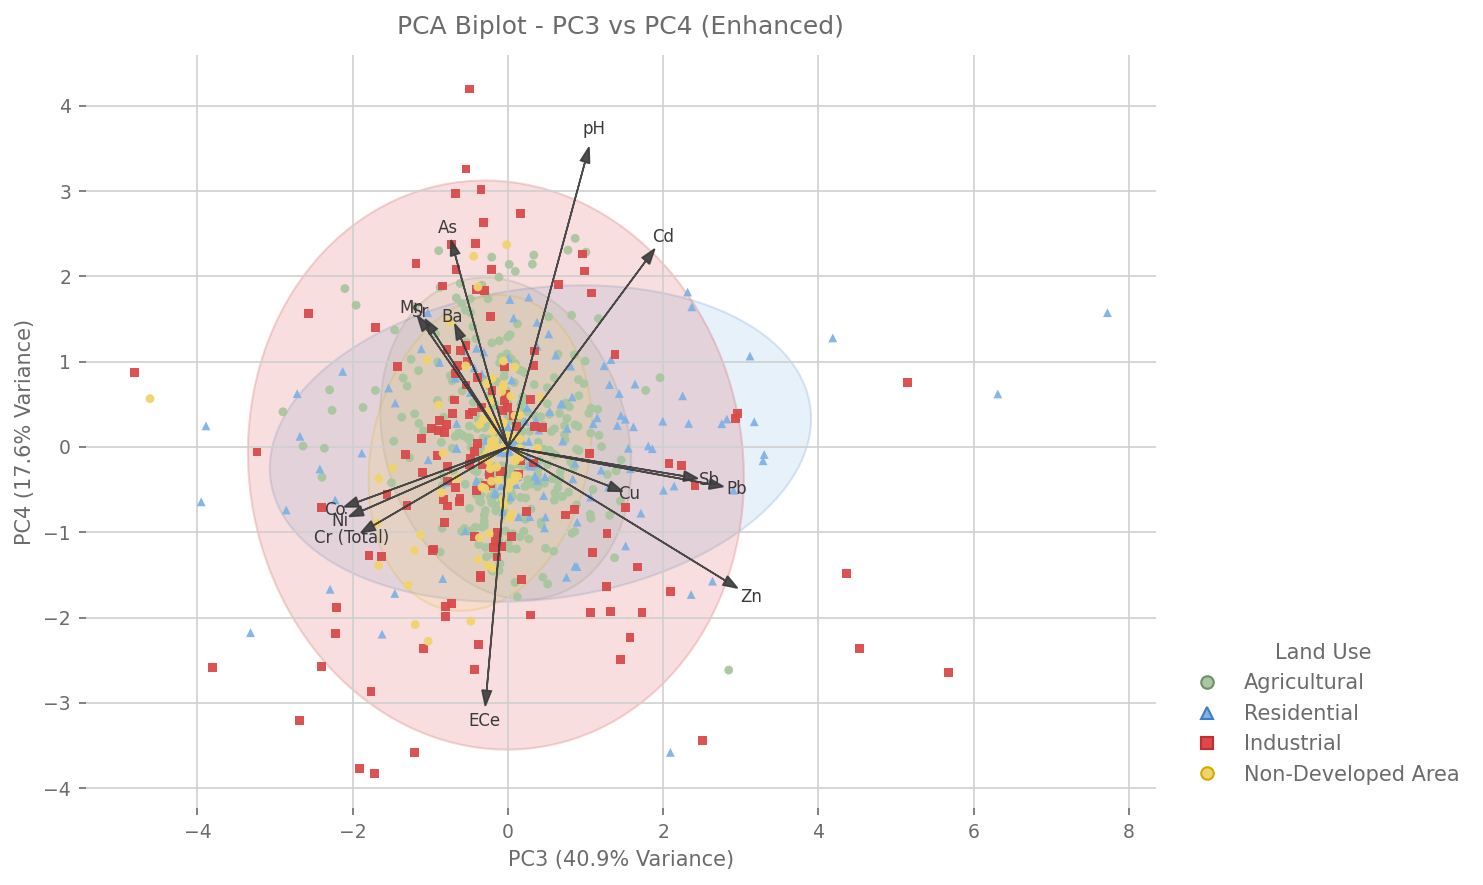

In [7]:
# =========================
# Step 6) PCA biplot PC3 vs PC4 (Enhanced)
# =========================

TEXT_COLOR = "#6B6B6B"
GRID_COLOR = "#cfcfcf"
ZERO_LINE_COLOR = "#7f7f7f"

# 90% chi-square quantile for df=2
CHI2_95_DF2 = 4.605


def confidence_ellipse_params(xy: np.ndarray, chi2_val: float = CHI2_95_DF2):
    """
    Return (mean_x, mean_y, width, height, angle_deg) for covariance ellipse scaled by chi-square.
    """
    if xy.shape[0] < 3:
        return None

    mu = xy.mean(axis=0)
    cov = np.cov(xy.T)

    # eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    # semi-axis lengths scaled by chi2; Ellipse width/height are full lengths
    width = 2 * np.sqrt(max(eigvals[0], 0) * chi2_val)
    height = 2 * np.sqrt(max(eigvals[1], 0) * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))
    return mu[0], mu[1], width, height, angle


def add_cov_ellipse(ax, xy, facecolor, edgecolor, alpha=0.16, lw=1.0, zorder=1):
    p = confidence_ellipse_params(xy)
    if p is None:
        return
    mx, my, w, h, ang = p
    ell = Ellipse((mx, my), width=w, height=h, angle=ang,
                  facecolor=facecolor, edgecolor=edgecolor, lw=lw, alpha=alpha, zorder=zorder)
    ax.add_patch(ell)


# ---- style for land use (match your sample: green/blue/red/yellow with distinct markers) ----
STYLE = {
    7: dict(label="Agricultural",        color="#A8C69F", edge="#6F8F66", marker="o"),
    8: dict(label="Residential",         color="#7FB2E6", edge="#3E7FBF", marker="^"),
    9: dict(label="Industrial",          color="#D94A4A", edge="#C92A2A", marker="s"),
    11: dict(label="Non-Developed Area", color="#F1D36B", edge="#D2A900", marker="o"),
}

# ---- choose PCs ----
pc_x, pc_y = 3, 4
xcol, ycol = f"PC{pc_x}", f"PC{pc_y}"

# ---- build figure ----
fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.set_facecolor("white")

# major grid only
ax.grid(True, which="major", color=GRID_COLOR, linewidth=0.8)
ax.minorticks_off()

# ---- scatter + ellipse per class ----
handles = []
for sid, st in STYLE.items():
    sub = df_pca[df_pca["SurveyID"] == sid]
    if sub.empty:
        continue

    xy = sub[[xcol, ycol]].to_numpy()

    ax.scatter(
        xy[:, 0], xy[:, 1],
        s=18,
        marker=st["marker"],
        c=st["color"],
        edgecolors="none",
        alpha=0.95,
        zorder=2
    )

    # 95% covariance ellipse
    add_cov_ellipse(
        ax, xy,
        facecolor=st["color"],
        edgecolor=st["edge"],
        alpha=0.18,
        lw=1.0,
        zorder=1
    )

    # legend handle
    handles.append(
        plt.Line2D([0], [0], marker=st["marker"], color="none",
                   markerfacecolor=st["color"], markeredgecolor=st["edge"],
                   markersize=6, label=st["label"])
    )

# ---- arrows (loadings) ----
# Use a scaling that fits arrows nicely relative to score spread
x_span = np.quantile(df_pca[xcol], 0.99) - np.quantile(df_pca[xcol], 0.01)
y_span = np.quantile(df_pca[ycol], 0.99) - np.quantile(df_pca[ycol], 0.01)
score_span = max(x_span, y_span)
arrow_scale = score_span  # tune if needed (0.35-0.55)

# pretty labels for features
inv_element_dict = {v: k for k, v in element_dict.items()}
feat_cols_exist = [c for c in element_dict.values() if c in df_pca.columns]
feat_labels = [inv_element_dict.get(c, c) for c in feat_cols_exist]

for col, lab in zip(feat_cols_exist, feat_labels):
    lx = float(loadings.loc[col, f"PC{pc_x}"]) * arrow_scale
    ly = float(loadings.loc[col, f"PC{pc_y}"]) * arrow_scale

    ax.arrow(
        0, 0, lx, ly,
        color="#3a3a3a",
        linewidth=0.8,
        head_width=0.12,
        head_length=0.18,
        length_includes_head=True,
        alpha=0.9,
        zorder=3
    )
    ax.text(
        lx * 1.06, ly * 1.06,
        lab,
        fontsize=8,
        color="#3a3a3a",
        ha="center", va="center",
        zorder=4
    )

# ---- labels / title ----
ax.set_title("PCA Biplot - PC3 vs PC4 (Enhanced)", color=TEXT_COLOR, pad=10)
ax.set_xlabel(f"PC3 ({explained_pct[0]:.1f}% Variance)", color=TEXT_COLOR)
ax.set_ylabel(f"PC4 ({explained_pct[1]:.1f}% Variance)", color=TEXT_COLOR)

# ticks style
ax.tick_params(axis="both", which="major", colors=TEXT_COLOR, labelsize=9)

# clean spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# legend
leg = ax.legend(
    handles=handles,
    title="Land Use",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.02),  # 👉 右侧、靠下、轴外
    frameon=False,
    borderaxespad=0.0
)
plt.setp(leg.get_title(), color=TEXT_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

plt.tight_layout()
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_GlobalPCA_PC3vsPC4.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_GlobalPCA_PC3vsPC4.svg"), bbox_inches="tight", pad_inches=0.1)

# Principal Component Analysis (PCA) -  Industrial

In [8]:
# -------------------------
# Config
# -------------------------
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]

TEXT_COLOR = "#6B6B6B"
GRID_COLOR = "#cfcfcf"

# 90% chi-square quantile for df=2 (用于椭圆尺度；你之前用这个值就保持一致)
CHI2_90_DF2 = 4.605

# Region style（按你示例图：Abu Dhabi=绿色方块，Al Ain=红色圆点，Al Dhafra=蓝色三角）
REGION_STYLE = {
    "Abu Dhabi": dict(label="Abu Dhabi", color="#6AA84F", edge="#38761D", marker="s"),
    "Al Ain":    dict(label="Al Ain",    color="#D94A4A", edge="#990000", marker="o"),
    "Al Dhafra": dict(label="Al Dhafra", color="#6FA8DC", edge="#1C4587", marker="^"),
}

# -------------------------
# Helper: covariance ellipse
# -------------------------
def confidence_ellipse_params(xy: np.ndarray, chi2_val: float = CHI2_90_DF2):
    """Return (mean_x, mean_y, width, height, angle_deg) for covariance ellipse scaled by chi-square."""
    if xy.shape[0] < 3:
        return None

    mu = xy.mean(axis=0)
    cov = np.cov(xy.T)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    width  = 2 * np.sqrt(max(eigvals[0], 0) * chi2_val)
    height = 2 * np.sqrt(max(eigvals[1], 0) * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))
    return mu[0], mu[1], width, height, angle


def add_cov_ellipse(ax, xy, facecolor, edgecolor, alpha=0.14, lw=1.0, zorder=1):
    p = confidence_ellipse_params(xy)
    if p is None:
        return
    mx, my, w, h, ang = p
    ell = Ellipse((mx, my), width=w, height=h, angle=ang,
                  facecolor=facecolor, edgecolor=edgecolor, lw=lw, alpha=alpha, zorder=zorder)
    ax.add_patch(ell)

[INFO] PCA features: ['satec', 'satph', 'Arsenic', 'Barium', 'Cadmium', 'Cobalt', 'Chromium_Total', 'Copper', 'Manganese', 'Nickel_aqua', 'Lead_aqua', 'Antimony', 'Strontium', 'Zinc']
[INFO] PCA rows: 169 -> 139 (dropped 30 rows with NaN)
[INFO] X shape: (139, 14)


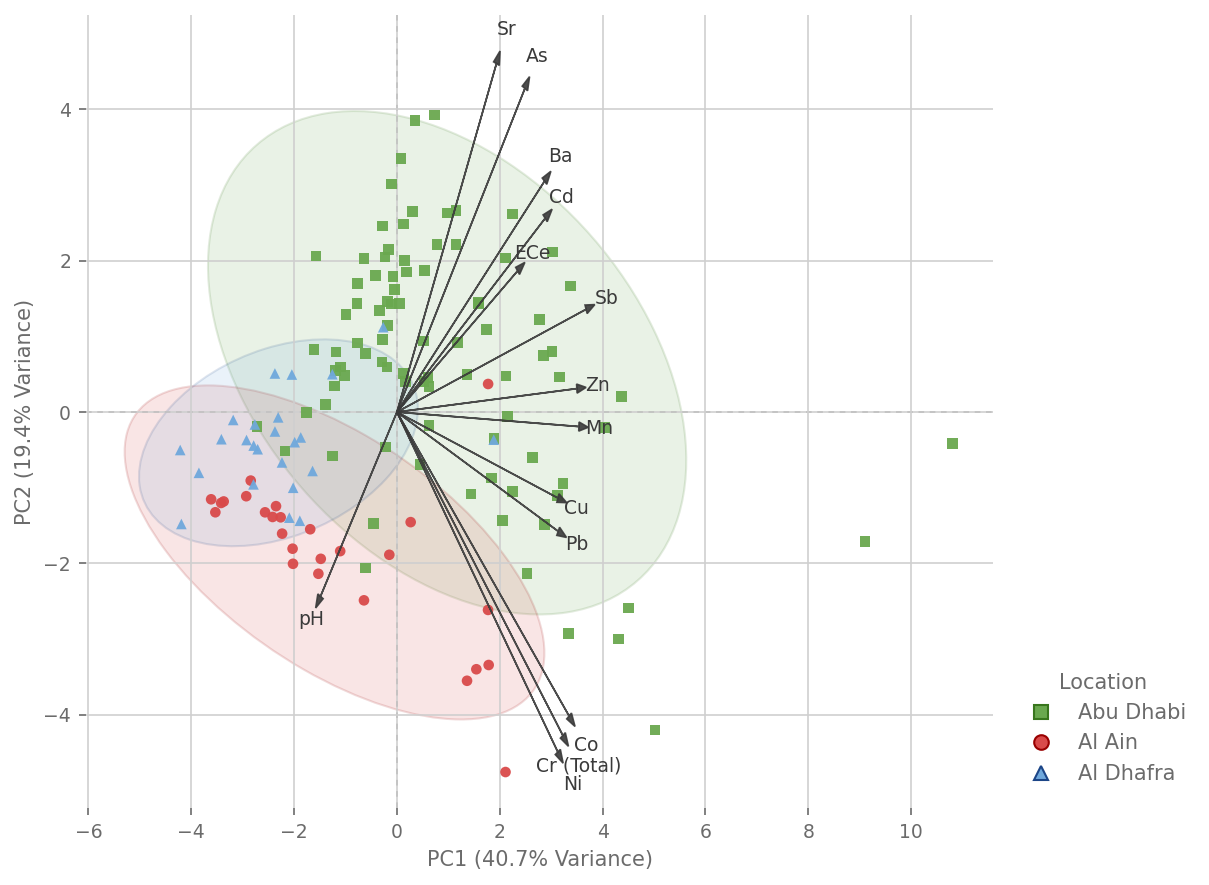

In [9]:
# ============================================================
# Step 1) PCA 输入变量准备（Industrial only）
# ============================================================

# 1) PCA 特征列（数据列名）
feat_cols = list(element_dict.values())

# 2) 只保留存在的列
feat_cols_exist = [c for c in feat_cols if c in ind_df.columns]
feat_cols_missing = [c for c in feat_cols if c not in ind_df.columns]
print("[INFO] PCA features:", feat_cols_exist)
if feat_cols_missing:
    print("[WARN] Missing PCA columns (ignored):", feat_cols_missing)

# 3) 只取工业用地，并限制 region（避免混入别的 location）
df_pca = ind_df.copy()
df_pca = df_pca[df_pca["Location"].isin(regions)].copy()

# 4) 强制数值化
for c in feat_cols_exist:
    df_pca[c] = pd.to_numeric(df_pca[c], errors="coerce")

# 5) 去掉 PCA 变量缺失的样本
before = len(df_pca)
df_pca = df_pca.dropna(subset=feat_cols_exist).copy()
after = len(df_pca)
print(f"[INFO] PCA rows: {before} -> {after} (dropped {before-after} rows with NaN)")

# 6) 重置索引（防 IndexError）
df_pca = df_pca.reset_index(drop=True)

# 7) X 矩阵 + region 标签
X = df_pca[feat_cols_exist].to_numpy()
y_region = df_pca["Location"].to_numpy()
print("[INFO] X shape:", X.shape)

# ============================================================
# Step 2) Standardization + PCA
# ============================================================

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

n_pc = min(10, X_std.shape[1])
pca = PCA(n_components=n_pc)
scores = pca.fit_transform(X_std)

explained_pct = pca.explained_variance_ratio_ * 100

# loadings: index=feature column, columns=PC1..PCn
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols_exist,
    columns=[f"PC{i}" for i in range(1, n_pc + 1)]
)

# attach PC scores
for i in range(n_pc):
    df_pca[f"PC{i+1}"] = scores[:, i]

# ============================================================
# Step 3) PCA biplot: PC1 vs PC2 (by Region)
# ============================================================

pc_x, pc_y = 1, 2
xcol, ycol = f"PC{pc_x}", f"PC{pc_y}"

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.set_facecolor("white")

# major grid only
ax.grid(True, which="major", color=GRID_COLOR, linewidth=0.8)
ax.minorticks_off()

# scatter + ellipse per region
handles = []
for reg in regions:
    sub = df_pca[df_pca["Location"] == reg]
    if sub.empty:
        continue

    st = REGION_STYLE[reg]
    xy = sub[[xcol, ycol]].to_numpy()

    ax.scatter(
        xy[:, 0], xy[:, 1],
        s=26,
        marker=st["marker"],
        c=st["color"],
        edgecolors="none",
        alpha=0.95,
        zorder=2
    )

    add_cov_ellipse(
        ax, xy,
        facecolor=st["color"],
        edgecolor=st["edge"],
        alpha=0.14,
        lw=1.0,
        zorder=1
    )

    handles.append(
        plt.Line2D([0], [0], marker=st["marker"], color="none",
                   markerfacecolor=st["color"], markeredgecolor=st["edge"],
                   markersize=7, label=st["label"])
    )

# ---- arrows (loadings) ----
# pretty labels: data col -> display label
inv_element_dict = {v: k for k, v in element_dict.items()}
feat_labels = [inv_element_dict.get(c, c) for c in feat_cols_exist]

# scale arrows to score spread
x_span = np.quantile(df_pca[xcol], 0.99) - np.quantile(df_pca[xcol], 0.01)
y_span = np.quantile(df_pca[ycol], 0.99) - np.quantile(df_pca[ycol], 0.01)
arrow_scale = max(x_span, y_span)

for col, lab in zip(feat_cols_exist, feat_labels):
    lx = float(loadings.loc[col, f"PC{pc_x}"]) * arrow_scale
    ly = float(loadings.loc[col, f"PC{pc_y}"]) * arrow_scale

    ax.arrow(
        0, 0, lx, ly,
        color="#3a3a3a",
        linewidth=0.8,
        head_width=0.12,
        head_length=0.18,
        length_includes_head=True,
        alpha=0.9,
        zorder=3
    )
    ax.text(
        lx * 1.06, ly * 1.06,
        lab,
        fontsize=9,
        color="#3a3a3a",
        ha="center", va="center",
        zorder=4
    )

# ---- labels / title ----
ax.set_xlabel(f"PC1 ({explained_pct[0]:.1f}% Variance)", color=TEXT_COLOR)
ax.set_ylabel(f"PC2 ({explained_pct[1]:.1f}% Variance)", color=TEXT_COLOR)
ax.tick_params(axis="both", which="major", colors=TEXT_COLOR, labelsize=9)

# clean spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# zero lines（可选；如果你想要和你示例一致，保留）
ax.axhline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)
ax.axvline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)

# legend outside bottom-right
leg = ax.legend(
    handles=handles,
    title="Location",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.02),
    frameon=False,
    borderaxespad=0.0
)
plt.setp(leg.get_title(), color=TEXT_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_IndustrialPCA.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_IndustrialPCA.svg"), bbox_inches="tight", pad_inches=0.1)

# Principal Component Analysis (PCA) -  Residential

In [10]:
# -------------------------
# Config
# -------------------------
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]

TEXT_COLOR = "#6B6B6B"
GRID_COLOR = "#cfcfcf"

# 90% chi-square quantile for df=2 (用于椭圆尺度；你之前用这个值就保持一致)
CHI2_90_DF2 = 4.605

# Region style（按你示例图：Abu Dhabi=绿色方块，Al Ain=红色圆点，Al Dhafra=蓝色三角）
REGION_STYLE = {
    "Abu Dhabi": dict(label="Abu Dhabi", color="#6AA84F", edge="#38761D", marker="s"),
    "Al Ain":    dict(label="Al Ain",    color="#D94A4A", edge="#990000", marker="o"),
    "Al Dhafra": dict(label="Al Dhafra", color="#6FA8DC", edge="#1C4587", marker="^"),
}

# -------------------------
# Helper: covariance ellipse
# -------------------------
def confidence_ellipse_params(xy: np.ndarray, chi2_val: float = CHI2_90_DF2):
    """Return (mean_x, mean_y, width, height, angle_deg) for covariance ellipse scaled by chi-square."""
    if xy.shape[0] < 3:
        return None

    mu = xy.mean(axis=0)
    cov = np.cov(xy.T)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    width  = 2 * np.sqrt(max(eigvals[0], 0) * chi2_val)
    height = 2 * np.sqrt(max(eigvals[1], 0) * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))
    return mu[0], mu[1], width, height, angle


def add_cov_ellipse(ax, xy, facecolor, edgecolor, alpha=0.14, lw=1.0, zorder=1):
    p = confidence_ellipse_params(xy)
    if p is None:
        return
    mx, my, w, h, ang = p
    ell = Ellipse((mx, my), width=w, height=h, angle=ang,
                  facecolor=facecolor, edgecolor=edgecolor, lw=lw, alpha=alpha, zorder=zorder)
    ax.add_patch(ell)

[INFO] PCA features: ['satec', 'satph', 'Arsenic', 'Barium', 'Cadmium', 'Cobalt', 'Chromium_Total', 'Copper', 'Manganese', 'Nickel_aqua', 'Lead_aqua', 'Antimony', 'Strontium', 'Zinc']
[INFO] PCA rows: 150 -> 141 (dropped 9 rows with NaN)
[INFO] X shape: (141, 14)


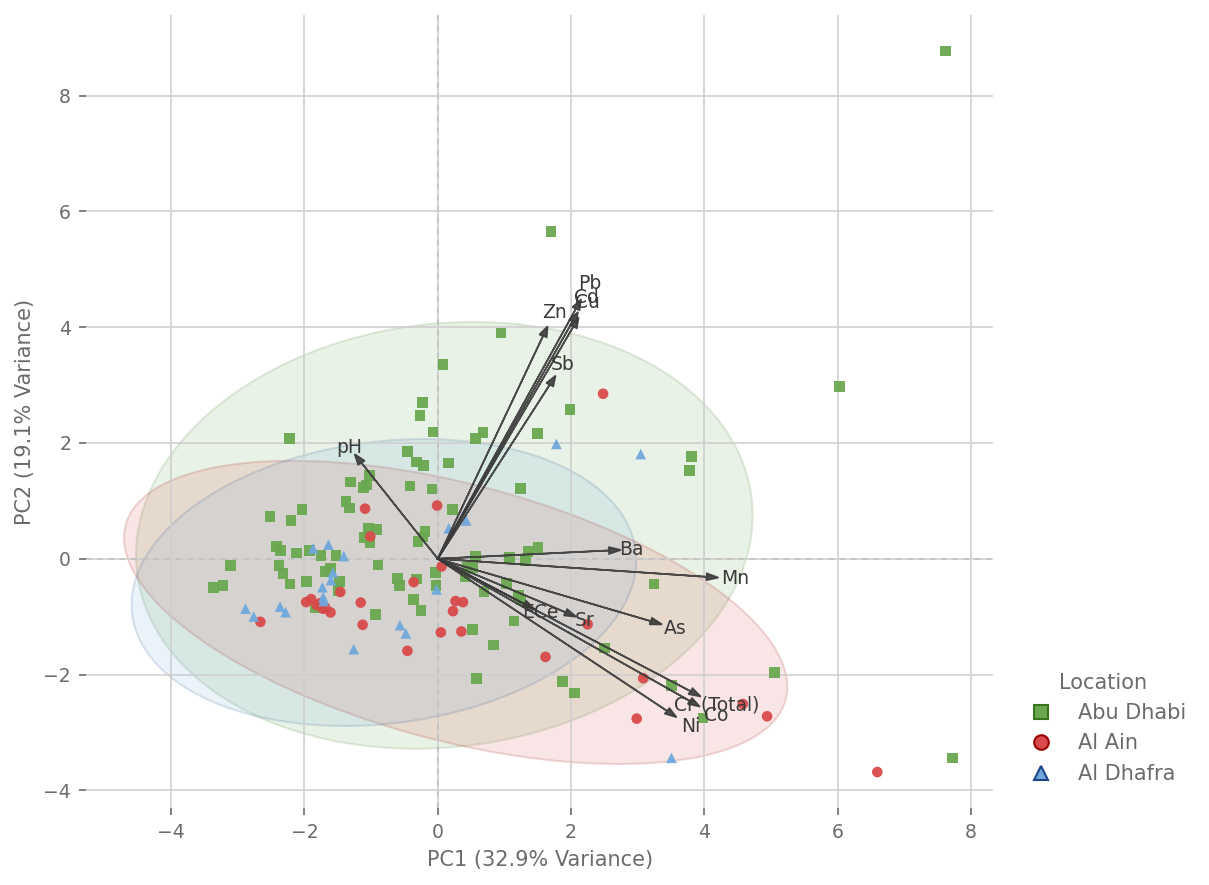

In [11]:
# ============================================================
# Step 1) PCA 输入变量准备（Industrial only）
# ============================================================

# 1) PCA 特征列（数据列名）
feat_cols = list(element_dict.values())

# 2) 只保留存在的列
feat_cols_exist = [c for c in feat_cols if c in ind_df.columns]
feat_cols_missing = [c for c in feat_cols if c not in ind_df.columns]
print("[INFO] PCA features:", feat_cols_exist)
if feat_cols_missing:
    print("[WARN] Missing PCA columns (ignored):", feat_cols_missing)

# 3) 只取工业用地，并限制 region（避免混入别的 location）
df_pca = res_df.copy()
df_pca = df_pca[df_pca["Location"].isin(regions)].copy()

# 4) 强制数值化
for c in feat_cols_exist:
    df_pca[c] = pd.to_numeric(df_pca[c], errors="coerce")

# 5) 去掉 PCA 变量缺失的样本
before = len(df_pca)
df_pca = df_pca.dropna(subset=feat_cols_exist).copy()
after = len(df_pca)
print(f"[INFO] PCA rows: {before} -> {after} (dropped {before-after} rows with NaN)")

# 6) 重置索引（防 IndexError）
df_pca = df_pca.reset_index(drop=True)

# 7) X 矩阵 + region 标签
X = df_pca[feat_cols_exist].to_numpy()
y_region = df_pca["Location"].to_numpy()
print("[INFO] X shape:", X.shape)

# ============================================================
# Step 2) Standardization + PCA
# ============================================================

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

n_pc = min(10, X_std.shape[1])
pca = PCA(n_components=n_pc)
scores = pca.fit_transform(X_std)

explained_pct = pca.explained_variance_ratio_ * 100

# loadings: index=feature column, columns=PC1..PCn
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols_exist,
    columns=[f"PC{i}" for i in range(1, n_pc + 1)]
)

# attach PC scores
for i in range(n_pc):
    df_pca[f"PC{i+1}"] = scores[:, i]

# ============================================================
# Step 3) PCA biplot: PC1 vs PC2 (by Region)
# ============================================================

pc_x, pc_y = 1, 2
xcol, ycol = f"PC{pc_x}", f"PC{pc_y}"

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.set_facecolor("white")

# major grid only
ax.grid(True, which="major", color=GRID_COLOR, linewidth=0.8)
ax.minorticks_off()

# scatter + ellipse per region
handles = []
for reg in regions:
    sub = df_pca[df_pca["Location"] == reg]
    if sub.empty:
        continue

    st = REGION_STYLE[reg]
    xy = sub[[xcol, ycol]].to_numpy()

    ax.scatter(
        xy[:, 0], xy[:, 1],
        s=26,
        marker=st["marker"],
        c=st["color"],
        edgecolors="none",
        alpha=0.95,
        zorder=2
    )

    add_cov_ellipse(
        ax, xy,
        facecolor=st["color"],
        edgecolor=st["edge"],
        alpha=0.14,
        lw=1.0,
        zorder=1
    )

    handles.append(
        plt.Line2D([0], [0], marker=st["marker"], color="none",
                   markerfacecolor=st["color"], markeredgecolor=st["edge"],
                   markersize=7, label=st["label"])
    )

# ---- arrows (loadings) ----
# pretty labels: data col -> display label
inv_element_dict = {v: k for k, v in element_dict.items()}
feat_labels = [inv_element_dict.get(c, c) for c in feat_cols_exist]

# scale arrows to score spread
x_span = np.quantile(df_pca[xcol], 0.99) - np.quantile(df_pca[xcol], 0.01)
y_span = np.quantile(df_pca[ycol], 0.99) - np.quantile(df_pca[ycol], 0.01)
arrow_scale = max(x_span, y_span)

for col, lab in zip(feat_cols_exist, feat_labels):
    lx = float(loadings.loc[col, f"PC{pc_x}"]) * arrow_scale
    ly = float(loadings.loc[col, f"PC{pc_y}"]) * arrow_scale

    ax.arrow(
        0, 0, lx, ly,
        color="#3a3a3a",
        linewidth=0.8,
        head_width=0.12,
        head_length=0.18,
        length_includes_head=True,
        alpha=0.9,
        zorder=3
    )
    ax.text(
        lx * 1.06, ly * 1.06,
        lab,
        fontsize=9,
        color="#3a3a3a",
        ha="center", va="center",
        zorder=4
    )

# ---- labels / title ----
ax.set_xlabel(f"PC1 ({explained_pct[0]:.1f}% Variance)", color=TEXT_COLOR)
ax.set_ylabel(f"PC2 ({explained_pct[1]:.1f}% Variance)", color=TEXT_COLOR)
ax.tick_params(axis="both", which="major", colors=TEXT_COLOR, labelsize=9)

# clean spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# zero lines（可选；如果你想要和你示例一致，保留）
ax.axhline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)
ax.axvline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)

# legend outside bottom-right
leg = ax.legend(
    handles=handles,
    title="Location",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.02),
    frameon=False,
    borderaxespad=0.0
)
plt.setp(leg.get_title(), color=TEXT_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_ResidentialPCA.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_ResidentialPCA.svg"), bbox_inches="tight", pad_inches=0.1)

# Principal Component Analysis (PCA) -  Agricultural

In [12]:
# -------------------------
# Config
# -------------------------
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]

TEXT_COLOR = "#6B6B6B"
GRID_COLOR = "#cfcfcf"

# 90% chi-square quantile for df=2 (用于椭圆尺度；你之前用这个值就保持一致)
CHI2_90_DF2 = 4.605

# Region style（按你示例图：Abu Dhabi=绿色方块，Al Ain=红色圆点，Al Dhafra=蓝色三角）
REGION_STYLE = {
    "Abu Dhabi": dict(label="Abu Dhabi", color="#6AA84F", edge="#38761D", marker="s"),
    "Al Ain":    dict(label="Al Ain",    color="#D94A4A", edge="#990000", marker="o"),
    "Al Dhafra": dict(label="Al Dhafra", color="#6FA8DC", edge="#1C4587", marker="^"),
}

# -------------------------
# Helper: covariance ellipse
# -------------------------
def confidence_ellipse_params(xy: np.ndarray, chi2_val: float = CHI2_90_DF2):
    """Return (mean_x, mean_y, width, height, angle_deg) for covariance ellipse scaled by chi-square."""
    if xy.shape[0] < 3:
        return None

    mu = xy.mean(axis=0)
    cov = np.cov(xy.T)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    width  = 2 * np.sqrt(max(eigvals[0], 0) * chi2_val)
    height = 2 * np.sqrt(max(eigvals[1], 0) * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))
    return mu[0], mu[1], width, height, angle


def add_cov_ellipse(ax, xy, facecolor, edgecolor, alpha=0.14, lw=1.0, zorder=1):
    p = confidence_ellipse_params(xy)
    if p is None:
        return
    mx, my, w, h, ang = p
    ell = Ellipse((mx, my), width=w, height=h, angle=ang,
                  facecolor=facecolor, edgecolor=edgecolor, lw=lw, alpha=alpha, zorder=zorder)
    ax.add_patch(ell)

[INFO] PCA features: ['satec', 'satph', 'Arsenic', 'Barium', 'Cadmium', 'Cobalt', 'Chromium_Total', 'Copper', 'Manganese', 'Nickel_aqua', 'Lead_aqua', 'Antimony', 'Strontium', 'Zinc']
[INFO] PCA rows: 306 -> 298 (dropped 8 rows with NaN)
[INFO] X shape: (298, 14)


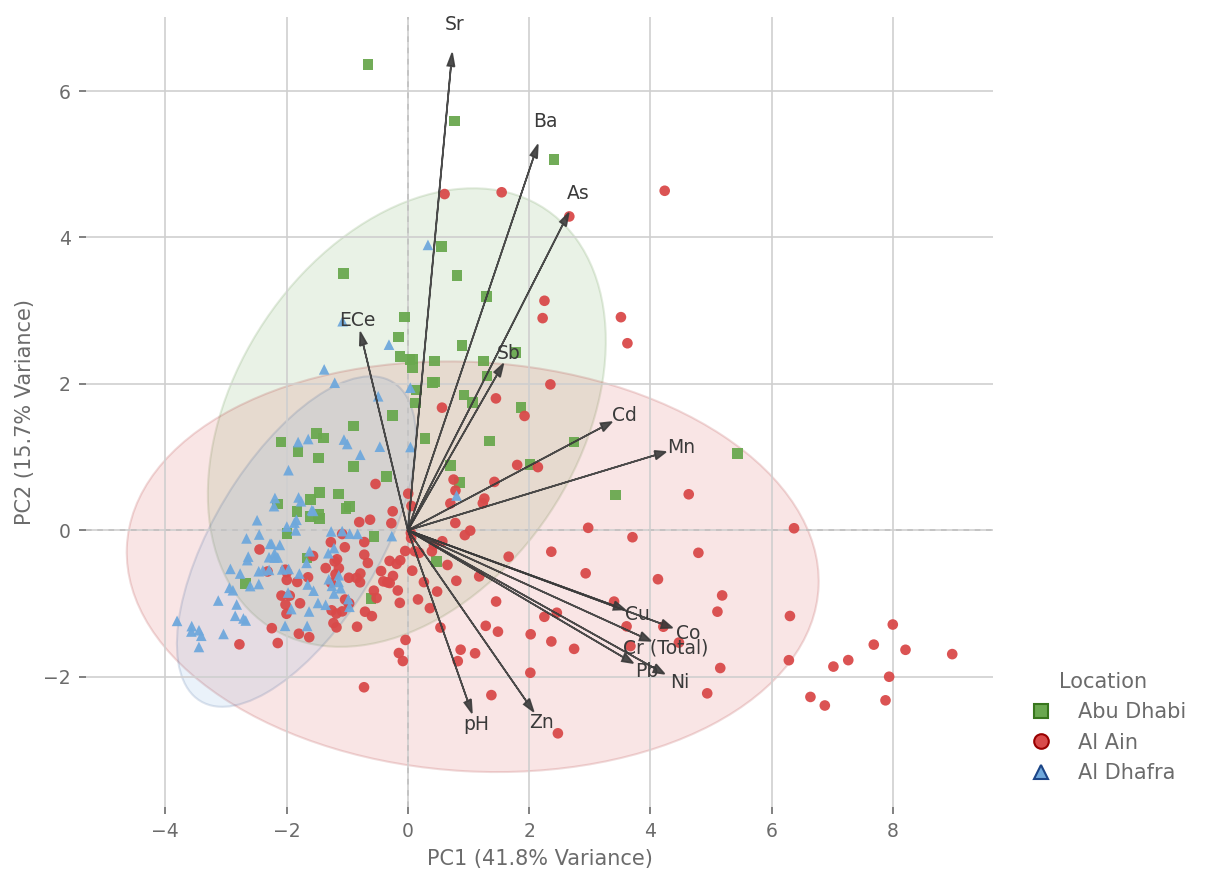

In [13]:
# ============================================================
# Step 1) PCA 输入变量准备（Industrial only）
# ============================================================

# 1) PCA 特征列（数据列名）
feat_cols = list(element_dict.values())

# 2) 只保留存在的列
feat_cols_exist = [c for c in feat_cols if c in ind_df.columns]
feat_cols_missing = [c for c in feat_cols if c not in ind_df.columns]
print("[INFO] PCA features:", feat_cols_exist)
if feat_cols_missing:
    print("[WARN] Missing PCA columns (ignored):", feat_cols_missing)

# 3) 只取工业用地，并限制 region（避免混入别的 location）
df_pca = agr_df.copy()
df_pca = df_pca[df_pca["Location"].isin(regions)].copy()

# 4) 强制数值化
for c in feat_cols_exist:
    df_pca[c] = pd.to_numeric(df_pca[c], errors="coerce")

# 5) 去掉 PCA 变量缺失的样本
before = len(df_pca)
df_pca = df_pca.dropna(subset=feat_cols_exist).copy()
after = len(df_pca)
print(f"[INFO] PCA rows: {before} -> {after} (dropped {before-after} rows with NaN)")

# 6) 重置索引（防 IndexError）
df_pca = df_pca.reset_index(drop=True)

# 7) X 矩阵 + region 标签
X = df_pca[feat_cols_exist].to_numpy()
y_region = df_pca["Location"].to_numpy()
print("[INFO] X shape:", X.shape)

# ============================================================
# Step 2) Standardization + PCA
# ============================================================

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

n_pc = min(10, X_std.shape[1])
pca = PCA(n_components=n_pc)
scores = pca.fit_transform(X_std)

explained_pct = pca.explained_variance_ratio_ * 100

# loadings: index=feature column, columns=PC1..PCn
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols_exist,
    columns=[f"PC{i}" for i in range(1, n_pc + 1)]
)

# attach PC scores
for i in range(n_pc):
    df_pca[f"PC{i+1}"] = scores[:, i]

# ============================================================
# Step 3) PCA biplot: PC1 vs PC2 (by Region)
# ============================================================

pc_x, pc_y = 1, 2
xcol, ycol = f"PC{pc_x}", f"PC{pc_y}"

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.set_facecolor("white")

# major grid only
ax.grid(True, which="major", color=GRID_COLOR, linewidth=0.8)
ax.minorticks_off()

# scatter + ellipse per region
handles = []
for reg in regions:
    sub = df_pca[df_pca["Location"] == reg]
    if sub.empty:
        continue

    st = REGION_STYLE[reg]
    xy = sub[[xcol, ycol]].to_numpy()

    ax.scatter(
        xy[:, 0], xy[:, 1],
        s=26,
        marker=st["marker"],
        c=st["color"],
        edgecolors="none",
        alpha=0.95,
        zorder=2
    )

    add_cov_ellipse(
        ax, xy,
        facecolor=st["color"],
        edgecolor=st["edge"],
        alpha=0.14,
        lw=1.0,
        zorder=1
    )

    handles.append(
        plt.Line2D([0], [0], marker=st["marker"], color="none",
                   markerfacecolor=st["color"], markeredgecolor=st["edge"],
                   markersize=7, label=st["label"])
    )

# ---- arrows (loadings) ----
# pretty labels: data col -> display label
inv_element_dict = {v: k for k, v in element_dict.items()}
feat_labels = [inv_element_dict.get(c, c) for c in feat_cols_exist]

# scale arrows to score spread
x_span = np.quantile(df_pca[xcol], 0.99) - np.quantile(df_pca[xcol], 0.01)
y_span = np.quantile(df_pca[ycol], 0.99) - np.quantile(df_pca[ycol], 0.01)
arrow_scale = max(x_span, y_span)

for col, lab in zip(feat_cols_exist, feat_labels):
    lx = float(loadings.loc[col, f"PC{pc_x}"]) * arrow_scale
    ly = float(loadings.loc[col, f"PC{pc_y}"]) * arrow_scale

    ax.arrow(
        0, 0, lx, ly,
        color="#3a3a3a",
        linewidth=0.8,
        head_width=0.12,
        head_length=0.18,
        length_includes_head=True,
        alpha=0.9,
        zorder=3
    )
    ax.text(
        lx * 1.06, ly * 1.06,
        lab,
        fontsize=9,
        color="#3a3a3a",
        ha="center", va="center",
        zorder=4
    )

# ---- labels / title ----
ax.set_xlabel(f"PC1 ({explained_pct[0]:.1f}% Variance)", color=TEXT_COLOR)
ax.set_ylabel(f"PC2 ({explained_pct[1]:.1f}% Variance)", color=TEXT_COLOR)
ax.tick_params(axis="both", which="major", colors=TEXT_COLOR, labelsize=9)

# clean spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# zero lines（可选；如果你想要和你示例一致，保留）
ax.axhline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)
ax.axvline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)

# legend outside bottom-right
leg = ax.legend(
    handles=handles,
    title="Location",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.02),
    frameon=False,
    borderaxespad=0.0
)
plt.setp(leg.get_title(), color=TEXT_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_AgriculturalPCA.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_AgriculturalPCA.svg"), bbox_inches="tight", pad_inches=0.1)

# Principal Component Analysis (PCA) -  Non-developed

In [14]:
# -------------------------
# Config
# -------------------------
regions = ["Abu Dhabi", "Al Ain", "Al Dhafra"]

TEXT_COLOR = "#6B6B6B"
GRID_COLOR = "#cfcfcf"

# 90% chi-square quantile for df=2 (用于椭圆尺度；你之前用这个值就保持一致)
CHI2_90_DF2 = 4.605

# Region style（按你示例图：Abu Dhabi=绿色方块，Al Ain=红色圆点，Al Dhafra=蓝色三角）
REGION_STYLE = {
    "Abu Dhabi": dict(label="Abu Dhabi", color="#6AA84F", edge="#38761D", marker="s"),
    "Al Ain":    dict(label="Al Ain",    color="#D94A4A", edge="#990000", marker="o"),
    "Al Dhafra": dict(label="Al Dhafra", color="#6FA8DC", edge="#1C4587", marker="^"),
}

# -------------------------
# Helper: covariance ellipse
# -------------------------
def confidence_ellipse_params(xy: np.ndarray, chi2_val: float = CHI2_90_DF2):
    """Return (mean_x, mean_y, width, height, angle_deg) for covariance ellipse scaled by chi-square."""
    if xy.shape[0] < 3:
        return None

    mu = xy.mean(axis=0)
    cov = np.cov(xy.T)

    eigvals, eigvecs = np.linalg.eigh(cov)
    order = np.argsort(eigvals)[::-1]
    eigvals = eigvals[order]
    eigvecs = eigvecs[:, order]

    width  = 2 * np.sqrt(max(eigvals[0], 0) * chi2_val)
    height = 2 * np.sqrt(max(eigvals[1], 0) * chi2_val)

    vx, vy = eigvecs[:, 0]
    angle = np.degrees(np.arctan2(vy, vx))
    return mu[0], mu[1], width, height, angle


def add_cov_ellipse(ax, xy, facecolor, edgecolor, alpha=0.14, lw=1.0, zorder=1):
    p = confidence_ellipse_params(xy)
    if p is None:
        return
    mx, my, w, h, ang = p
    ell = Ellipse((mx, my), width=w, height=h, angle=ang,
                  facecolor=facecolor, edgecolor=edgecolor, lw=lw, alpha=alpha, zorder=zorder)
    ax.add_patch(ell)

[INFO] PCA features: ['satec', 'satph', 'Arsenic', 'Barium', 'Cadmium', 'Cobalt', 'Chromium_Total', 'Copper', 'Manganese', 'Nickel_aqua', 'Lead_aqua', 'Antimony', 'Strontium', 'Zinc']
[INFO] PCA rows: 84 -> 81 (dropped 3 rows with NaN)
[INFO] X shape: (81, 14)


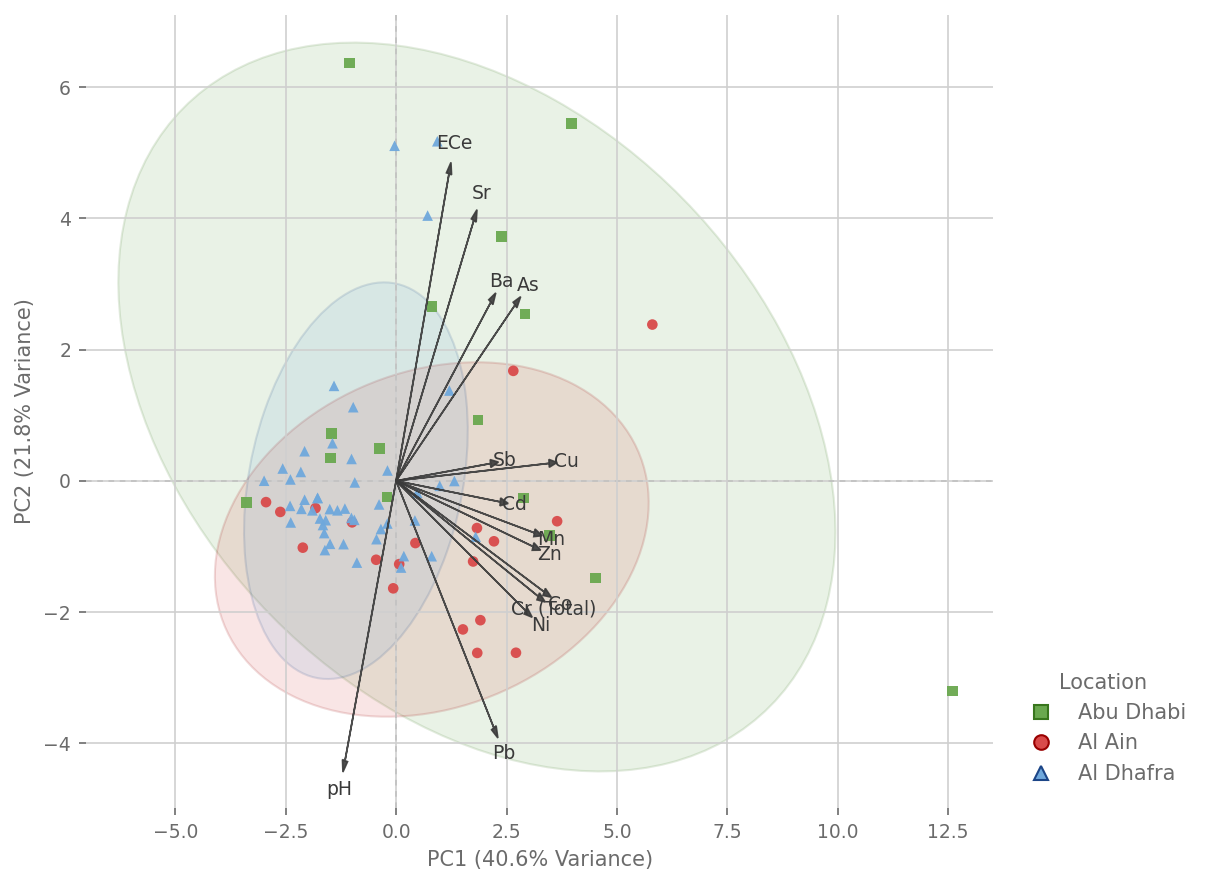

In [15]:
# ============================================================
# Step 1) PCA 输入变量准备（Industrial only）
# ============================================================

# 1) PCA 特征列（数据列名）
feat_cols = list(element_dict.values())

# 2) 只保留存在的列
feat_cols_exist = [c for c in feat_cols if c in ind_df.columns]
feat_cols_missing = [c for c in feat_cols if c not in ind_df.columns]
print("[INFO] PCA features:", feat_cols_exist)
if feat_cols_missing:
    print("[WARN] Missing PCA columns (ignored):", feat_cols_missing)

# 3) 只取工业用地，并限制 region（避免混入别的 location）
df_pca = non_df.copy()
df_pca = df_pca[df_pca["Location"].isin(regions)].copy()

# 4) 强制数值化
for c in feat_cols_exist:
    df_pca[c] = pd.to_numeric(df_pca[c], errors="coerce")

# 5) 去掉 PCA 变量缺失的样本
before = len(df_pca)
df_pca = df_pca.dropna(subset=feat_cols_exist).copy()
after = len(df_pca)
print(f"[INFO] PCA rows: {before} -> {after} (dropped {before-after} rows with NaN)")

# 6) 重置索引（防 IndexError）
df_pca = df_pca.reset_index(drop=True)

# 7) X 矩阵 + region 标签
X = df_pca[feat_cols_exist].to_numpy()
y_region = df_pca["Location"].to_numpy()
print("[INFO] X shape:", X.shape)

# ============================================================
# Step 2) Standardization + PCA
# ============================================================

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

n_pc = min(10, X_std.shape[1])
pca = PCA(n_components=n_pc)
scores = pca.fit_transform(X_std)

explained_pct = pca.explained_variance_ratio_ * 100

# loadings: index=feature column, columns=PC1..PCn
loadings = pd.DataFrame(
    pca.components_.T,
    index=feat_cols_exist,
    columns=[f"PC{i}" for i in range(1, n_pc + 1)]
)

# attach PC scores
for i in range(n_pc):
    df_pca[f"PC{i+1}"] = scores[:, i]

# ============================================================
# Step 3) PCA biplot: PC1 vs PC2 (by Region)
# ============================================================

pc_x, pc_y = 1, 2
xcol, ycol = f"PC{pc_x}", f"PC{pc_y}"

fig, ax = plt.subplots(figsize=(10, 6), dpi=150)
ax.set_facecolor("white")

# major grid only
ax.grid(True, which="major", color=GRID_COLOR, linewidth=0.8)
ax.minorticks_off()

# scatter + ellipse per region
handles = []
for reg in regions:
    sub = df_pca[df_pca["Location"] == reg]
    if sub.empty:
        continue

    st = REGION_STYLE[reg]
    xy = sub[[xcol, ycol]].to_numpy()

    ax.scatter(
        xy[:, 0], xy[:, 1],
        s=26,
        marker=st["marker"],
        c=st["color"],
        edgecolors="none",
        alpha=0.95,
        zorder=2
    )

    add_cov_ellipse(
        ax, xy,
        facecolor=st["color"],
        edgecolor=st["edge"],
        alpha=0.14,
        lw=1.0,
        zorder=1
    )

    handles.append(
        plt.Line2D([0], [0], marker=st["marker"], color="none",
                   markerfacecolor=st["color"], markeredgecolor=st["edge"],
                   markersize=7, label=st["label"])
    )

# ---- arrows (loadings) ----
# pretty labels: data col -> display label
inv_element_dict = {v: k for k, v in element_dict.items()}
feat_labels = [inv_element_dict.get(c, c) for c in feat_cols_exist]

# scale arrows to score spread
x_span = np.quantile(df_pca[xcol], 0.99) - np.quantile(df_pca[xcol], 0.01)
y_span = np.quantile(df_pca[ycol], 0.99) - np.quantile(df_pca[ycol], 0.01)
arrow_scale = max(x_span, y_span)

for col, lab in zip(feat_cols_exist, feat_labels):
    lx = float(loadings.loc[col, f"PC{pc_x}"]) * arrow_scale
    ly = float(loadings.loc[col, f"PC{pc_y}"]) * arrow_scale

    ax.arrow(
        0, 0, lx, ly,
        color="#3a3a3a",
        linewidth=0.8,
        head_width=0.12,
        head_length=0.18,
        length_includes_head=True,
        alpha=0.9,
        zorder=3
    )
    ax.text(
        lx * 1.06, ly * 1.06,
        lab,
        fontsize=9,
        color="#3a3a3a",
        ha="center", va="center",
        zorder=4
    )

# ---- labels / title ----
ax.set_xlabel(f"PC1 ({explained_pct[0]:.1f}% Variance)", color=TEXT_COLOR)
ax.set_ylabel(f"PC2 ({explained_pct[1]:.1f}% Variance)", color=TEXT_COLOR)
ax.tick_params(axis="both", which="major", colors=TEXT_COLOR, labelsize=9)

# clean spines
for spine in ["top", "right", "left", "bottom"]:
    ax.spines[spine].set_visible(False)

# zero lines（可选；如果你想要和你示例一致，保留）
ax.axhline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)
ax.axvline(0, color="#8a8a8a", linestyle=(0, (3, 3)), linewidth=0.9, zorder=0)

# legend outside bottom-right
leg = ax.legend(
    handles=handles,
    title="Location",
    loc="lower left",
    bbox_to_anchor=(1.02, 0.02),
    frameon=False,
    borderaxespad=0.0
)
plt.setp(leg.get_title(), color=TEXT_COLOR)
for t in leg.get_texts():
    t.set_color(TEXT_COLOR)

plt.tight_layout(rect=[0, 0, 0.82, 1])
plt.show()
fig.savefig(os.path.join(OUT_DIR, f"Ch12_NonDevelopedPCA.png"), bbox_inches="tight", pad_inches=0.1)
fig.savefig(os.path.join(OUT_DIR, f"Ch12_NonDevelopedPCA.svg"), bbox_inches="tight", pad_inches=0.1)